## Key findings and achievements

> * dsadsa
> * dsadsa

---

## Introduction

Customer retention plays a vital role in the sustainability and growth of any business. Retaining existing customers is often more cost-effective than acquiring new ones, and loyal customers can become brand advocates, driving further growth through positive word-of-mouth. However, understanding why customers churn is a complex task that requires a comprehensive analysis of various factors.

In this data science notebook, we focus on leveraging customer clustering as a powerful technique to address retention and churn. Clustering algorithms allow us to group customers into distinct segments based on shared characteristics, behaviors, or preferences. By identifying these segments, we can gain valuable insights into customer patterns and potentially uncover factors contributing to churn.

The insights derived from this analysis will enable us to develop targeted retention strategies tailored to each customer segment. By understanding the specific needs, preferences, and pain points of different customer groups, we can design personalized initiatives to mitigate churn and foster stronger customer loyalty.

Overall, this notebook aims to demonstrate the power of customer clustering in addressing retention and churn. By leveraging data-driven techniques, businesses can gain a competitive edge by proactively identifying potential churners, taking targeted actions, and ultimately fostering long-term customer relationships.

In [27]:
# data wrangling
import numpy as np
import pandas as pd
import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Data

Our dataset ([UCI Retail II]("https://archive-beta.ics.uci.edu/dataset/502/online+retail+ii")) is composed by two-year sales data from an online store based in the UK. Here below, a glimpse of it.

In [28]:
df = pd.read_parquet('../../data/concatenated_online_retail_II.parquet')

df = df.rename(columns={'Customer ID': 'CustomerID'})
df = df.dropna(subset='CustomerID', axis=0)

df['CustomerSince'] = df.groupby('CustomerID')[['InvoiceDate']].transform(min)
df['Lifespan'] = df['InvoiceDate'] - df['CustomerSince']
df['Lifespan_D'] = df['Lifespan'].dt.days
df['Lifespan_M'] = (df['Lifespan_D'] / 30.44).astype(int)
df['MonthlyCohort'] = pd.to_datetime(df['CustomerSince']).dt.to_period('M') #.dt.to_timestamp()
df['FirstTimeMonth'] = df['MonthlyCohort'].dt.month

df['Amount'] = df['Price'] * df['Quantity']

# Mapping regions
regions = {'Europe': ['Sweden', 'Denmark', 'Norway', 'Finland', 'Iceland', 'Netherlands', 'Belgium', 'France', 'Germany', 'Switzerland', 'Austria',
                      'Italy', 'Spain', 'Greece', 'Portugal', 'Malta', 'Cyprus', 'Czech Republic', 'Lithuania', 'Poland', 'United Kingdom', 'EIRE',
                      'Channel Islands', 'European Community'],
           'North America': ['USA', 'Canada'],
           'Middle East': ['Bahrain', 'United Arab Emirates', 'Israel', 'Lebanon', 'Saudi Arabia'],
           'Asia Pacific': ['Japan', 'Australia', 'Singapore', 'Hong Kong', 'Korea', 'Thailand'],
           'RoW': ['Brazil', 'RSA', 'West Indies', 'Nigeria', 'Bermuda'],
           'Unspecified': ['Unspecified']}

country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

df['Region'] = df['Country'].map(country_to_region)

# Subsetting
df = df[(df['Amount'] > 0) & (df['InvoiceDate'] < "2011-12-01")]

display(df.head())
print(f"Timeframe: {df['InvoiceDate'].min().date()} - {df['InvoiceDate'].max().date()}")

/var/folders/q6/vdj3_fwx643gzyb3rg6c4ygh0000gp/T/ipykernel_19281/2090943081.py:6: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df['CustomerSince'] = df.groupby('CustomerID')[['InvoiceDate']].transform(min)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Year,CustomerSince,Lifespan,Lifespan_D,Lifespan_M,MonthlyCohort,FirstTimeMonth,Amount,Region
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,0,2009-12,12,83.4,Europe
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,0,2009-12,12,81.0,Europe
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,0,2009-12,12,81.0,Europe
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,0,2009-12,12,100.8,Europe
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1,2009-12-01 07:45:00,0 days,0,0,2009-12,12,30.0,Europe


Timeframe: 2009-12-01 - 2011-11-30


<!-- ## New client acquisition -->

In [29]:
# bymc = df.groupby('MonthlyCohort').agg(
#     TotalAmount=('Amount', 'sum'),
#     Volume=('CustomerID', 'count')
# )
# fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
# bymc['TotalAmount'].plot(ax=ax)
# ax2 = plt.twiny()
# ax2.set_xticks([])
# ax3 = plt.twinx()
# bymc['Volume'].plot(ax=ax3, kind='bar', alpha=0.5)
# ax3.set_xticks([])

# # Add trendline
# x = np.arange(len(bymc))
# y = bymc['TotalAmount'].values
# coefficients = np.polyfit(x, y, deg=1)
# trendline = np.poly1d(coefficients)
# ax2.plot(x, trendline(x), color='red', linestyle='--', label='Regression')

# h1, l1 = ax.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# h3, l3 = ax3.get_legend_handles_labels()
# ax.legend(h1+h2+h3, l1+l2+l3)
# ax.set_xlabel('Monthly Cohort')
# ax.set_ylabel('GBP')
# ax3.set_ylabel('Frequency')
# plt.title("Time-Series Analysis: Evolution of Client Acquisition")
# ax.grid()
# plt.show()


# bym = df.groupby('FirstTimeMonth').size()

# fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
# bym.plot(kind='bar', ax=ax)
# for p in ax.patches:
#     count = (p.get_height() / bym.sum()).round(2)
#     x = p.get_x() + p.get_width() / 2
#     y = p.get_y() + p.get_height() + 5000
#     ax.annotate(f'{count}%', (x, y), ha='center', va='center')
# plt.ylabel('Frequency')
# plt.xlabel('Month of acquisition')
# plt.title('Time-Series Analysis: Client Acquisition per Month')
# plt.show()

## Exploring retention with cohort analysis

This chapter will guide us through the process of conducting cohort analysis to explore retention. We will start by defining cohorts based on relevant criteria, such as the customers' first purchase date. We will then analyze the retention rates of these cohorts over subsequent time periods, allowing us to observe how customer loyalty evolves over time.

In [30]:
df['Lifespan_M'].describe()

count    788244.000000
mean          7.674870
std           7.016554
min           0.000000
25%           1.000000
50%           6.000000
75%          13.000000
max          23.000000
Name: Lifespan_M, dtype: float64

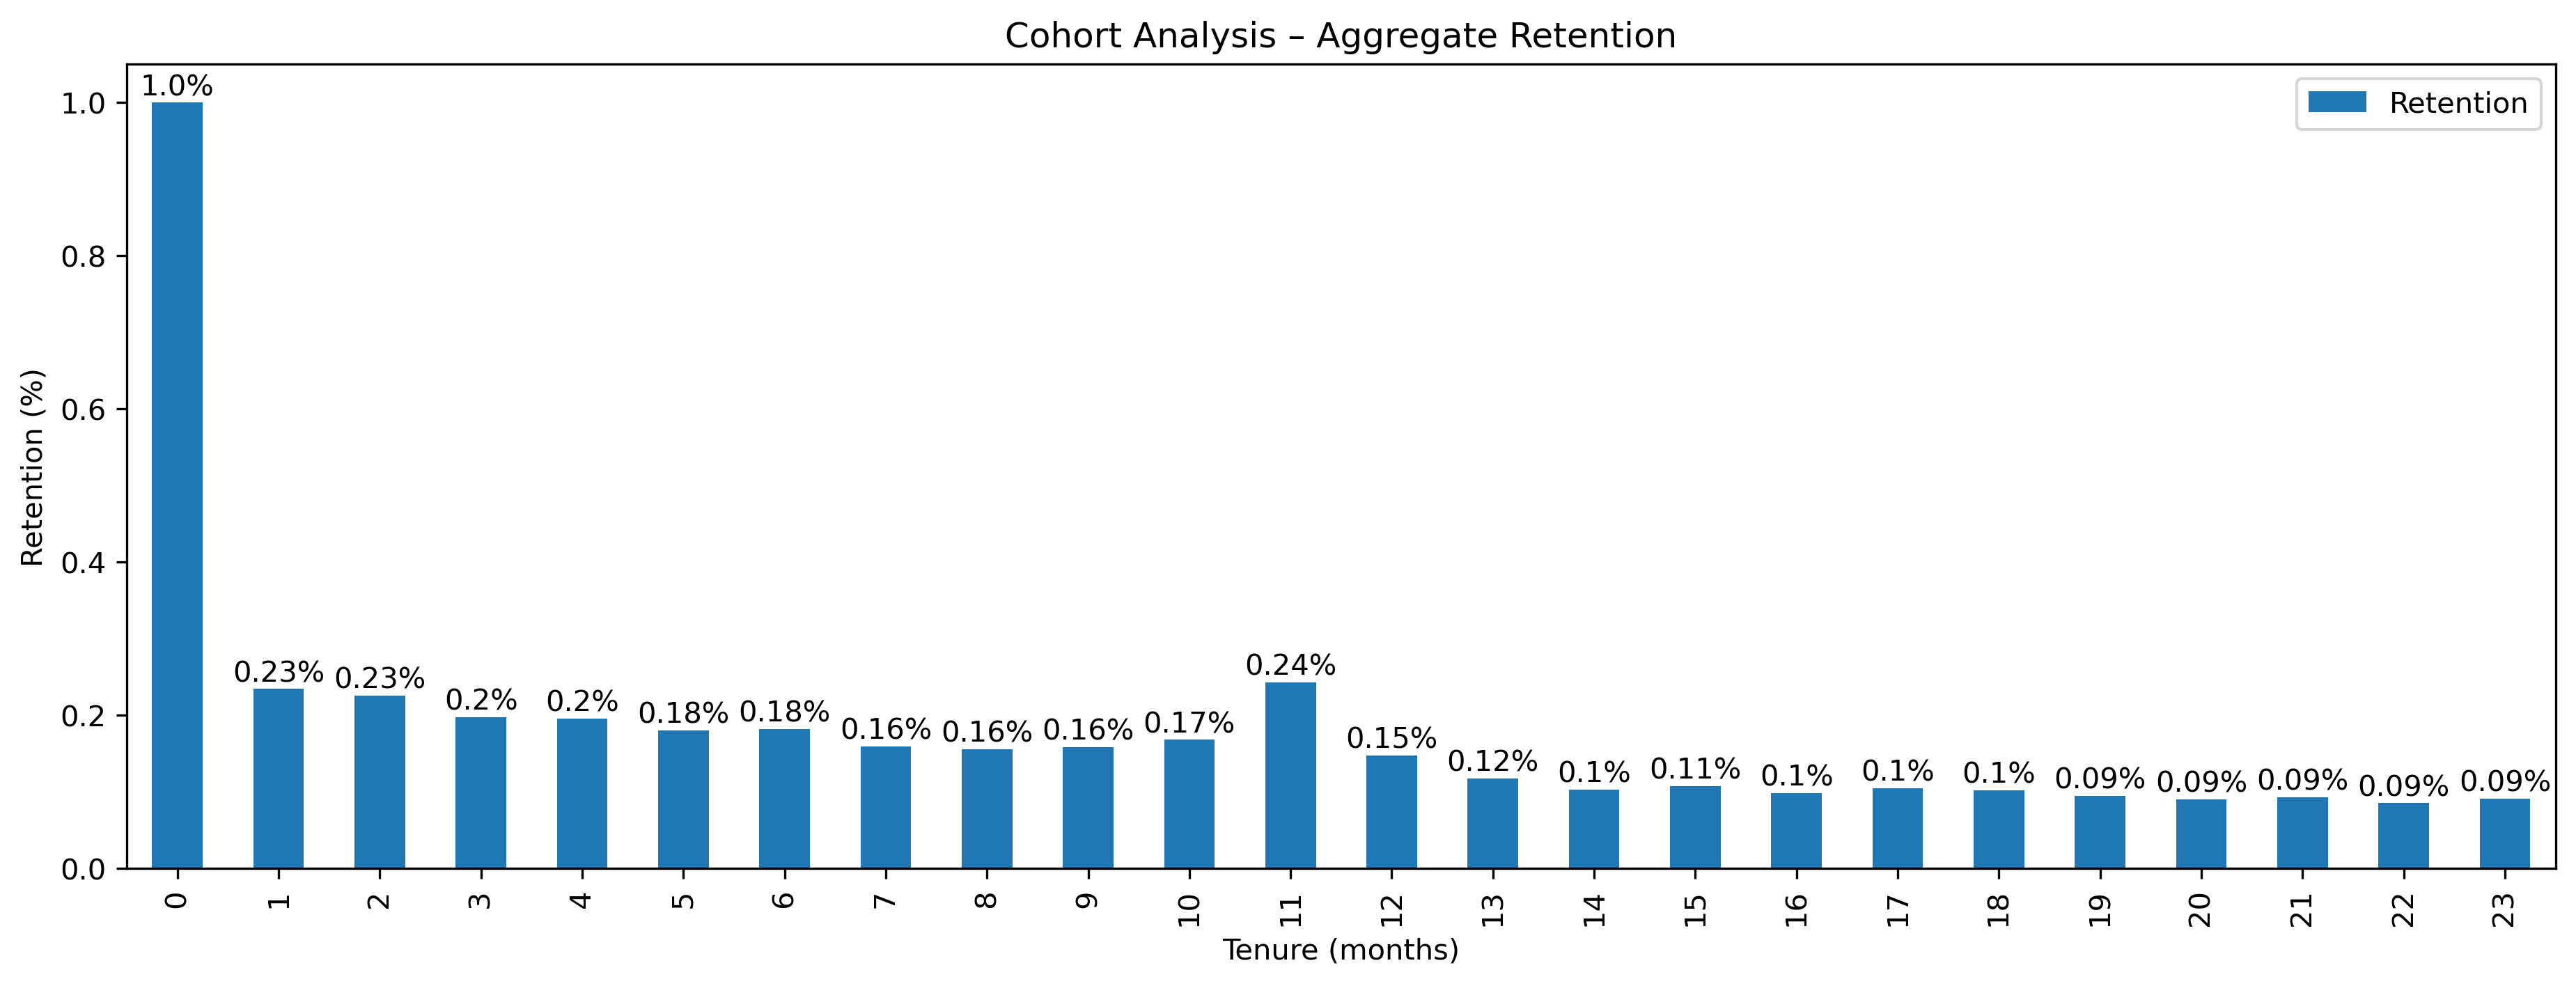

In [31]:
grouped_life_count = df.groupby('Lifespan_M')[['CustomerID']].count()
grouped_life_count = grouped_life_count.divide(grouped_life_count.iloc[0].item(), axis=0)
grouped_life_count = grouped_life_count.rename(columns={'CustomerID': 'Retention'})

fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
grouped_life_count.plot(kind='bar', ax=ax)
for p in ax.patches:
    count = p.get_height().round(2)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 0.02
    ax.annotate(f'{count}%', (x, y), ha='center', va='center')
plt.title("Cohort Analysis – Aggregate Retention")
plt.ylabel('Retention (%)')
plt.xlabel('Tenure (months)')
plt.show()

### Monthly Cohorts

The first step is to group customers by their first acquisition date (month) and their tenure (lifespan in number of months), and compute each cohort’s size and total revenue.

In [32]:
grouped_m = df.groupby(['MonthlyCohort', 'Lifespan_M']).agg(
    n=('CustomerID', 'count'),
    TotalAmount=('Amount', 'sum'),
    AvgAmount=('Amount', 'mean')).reset_index()
grouped_m

,MonthlyCohort,Lifespan_M,n,TotalAmount,AvgAmount
0,2009-12,0,32111,730976.720,22.764060
1,2009-12,1,13433,403375.071,30.028666
2,2009-12,2,13449,353813.642,26.307803
3,2009-12,3,13279,352853.150,26.572268
4,2009-12,4,14197,337613.590,23.780629
...,...,...,...,...,...
295,2011-09,1,1958,25230.280,12.885741
296,2011-09,2,1059,14487.250,13.680123
297,2011-10,0,9413,126462.600,13.434888
298,2011-10,1,1348,16033.750,11.894473


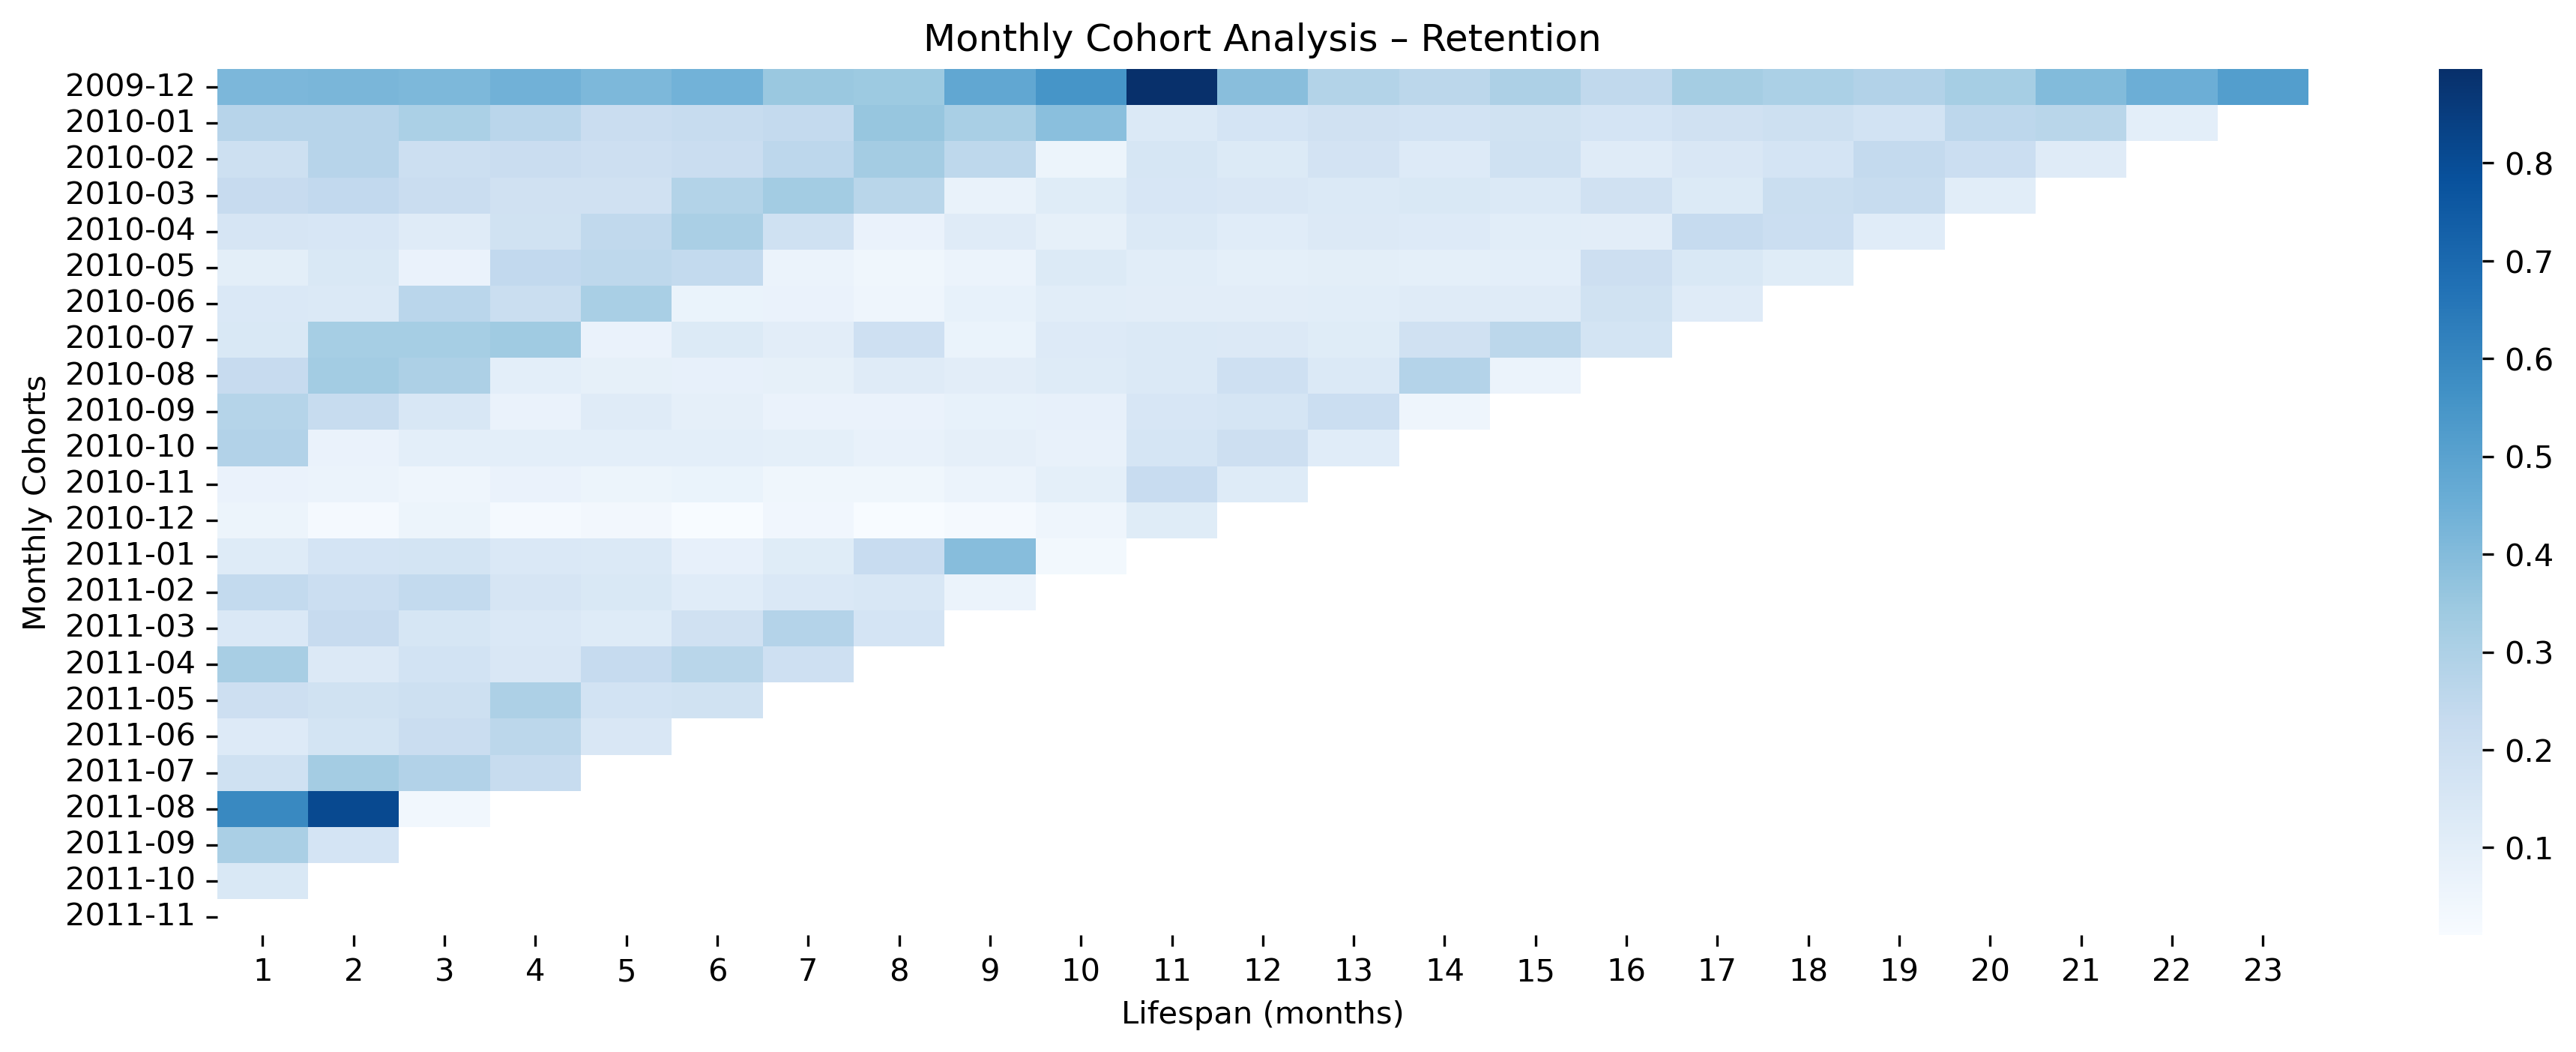

In [33]:
cohorts = grouped_m.reset_index(drop=True).pivot(index='MonthlyCohort', columns='Lifespan_M', values='n')
heatmap = cohorts.divide(cohorts.iloc[:, 0], axis=0)

plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(heatmap.iloc[:, 1:], cmap='Blues')
plt.title("Monthly Cohort Analysis – Retention")
plt.xlabel('Lifespan (months)')
plt.ylabel('Monthly Cohorts')
plt.show()

### Regional Cohorts

The cohort analysis can be extended to the geographical level by incorporating the "region" variable in the analysis. This can provide insights into the behaviors of customers across different regions.

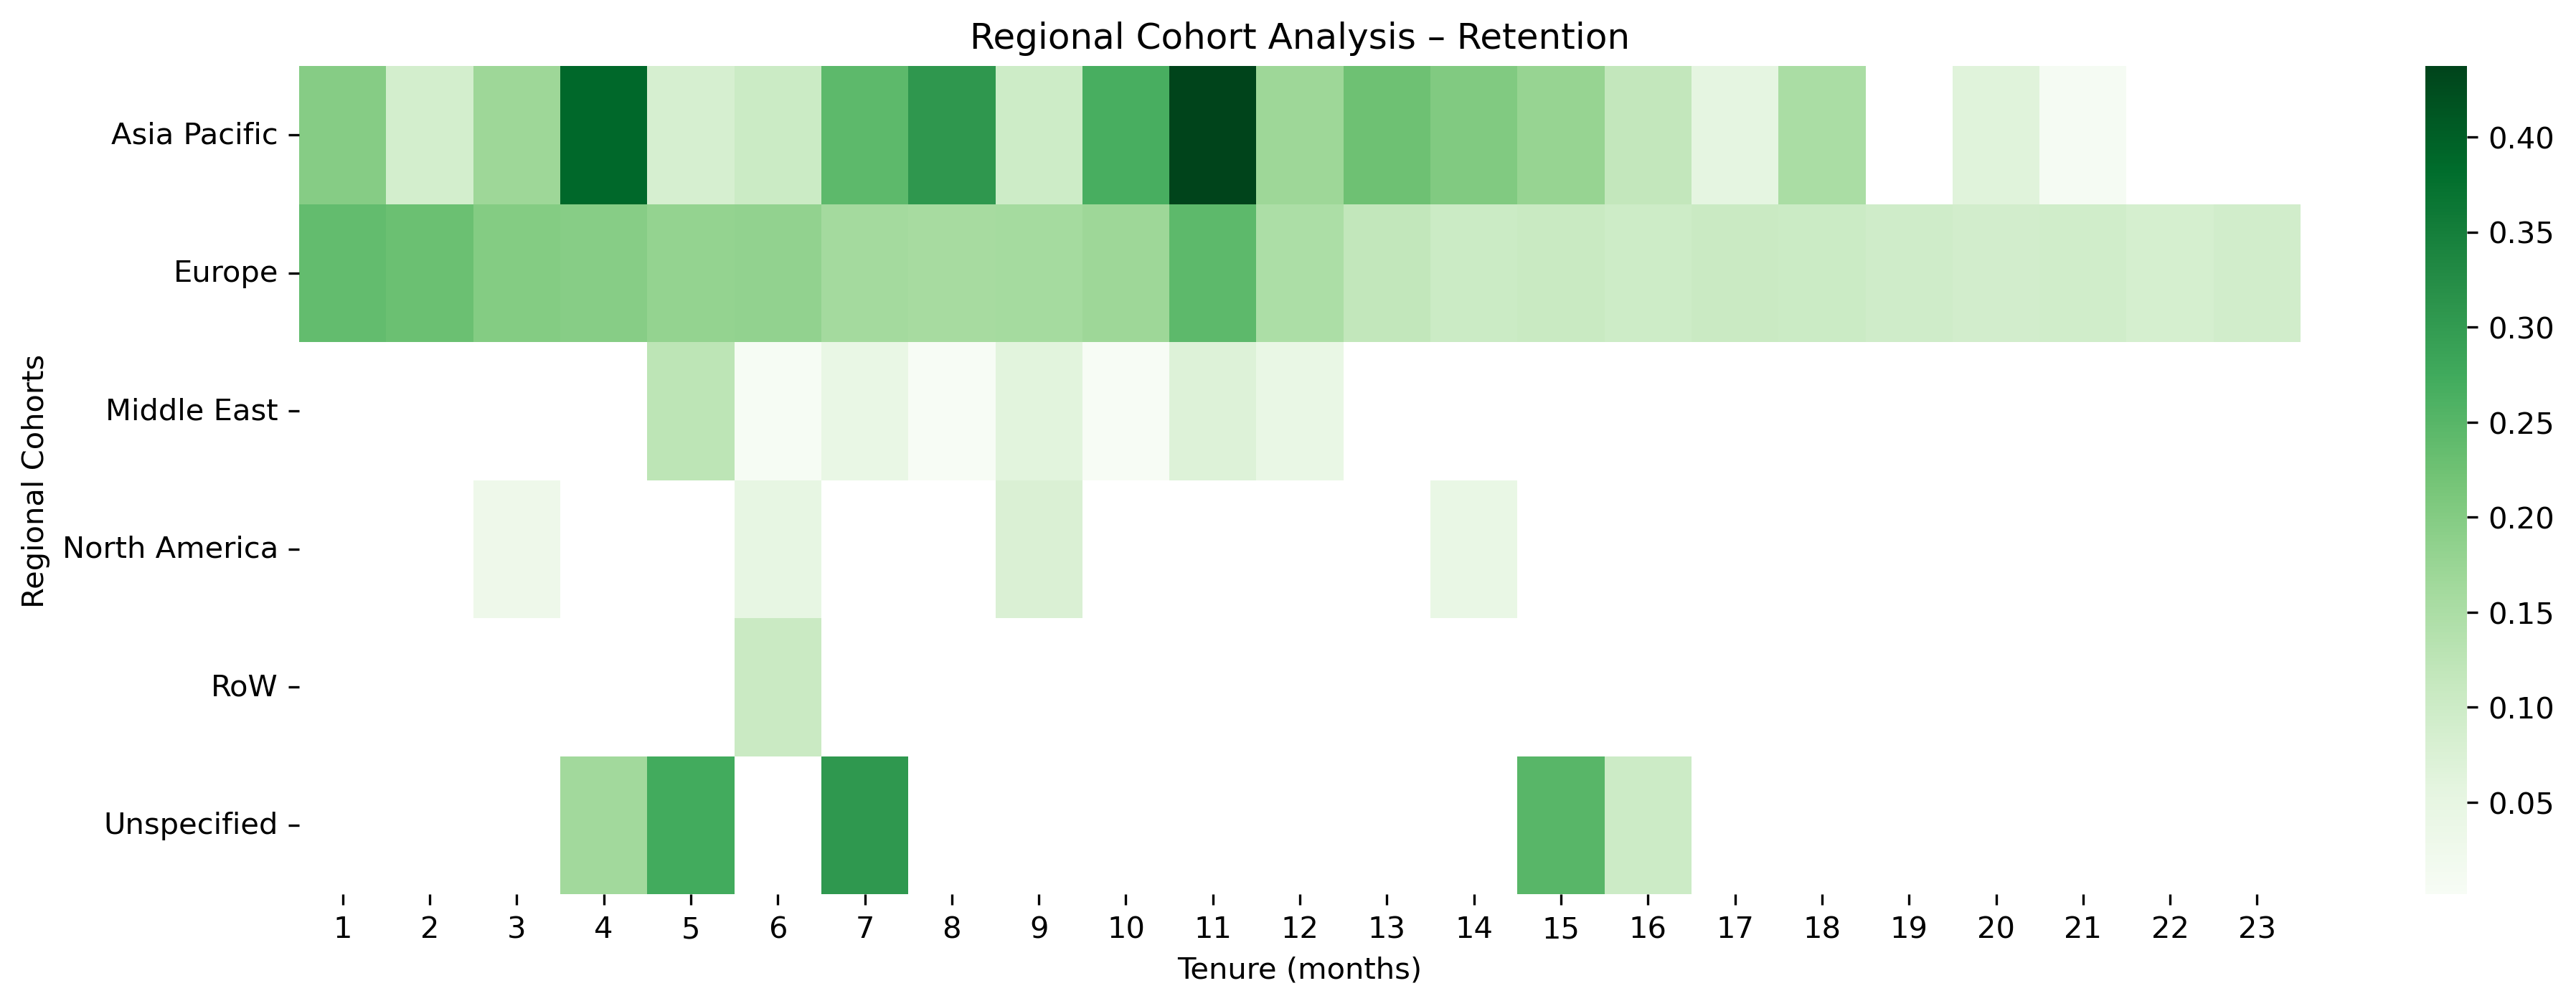

In [34]:
grouped_r = df.groupby(['Region', 'Lifespan_M']).agg(
    n=('CustomerID', 'count'),
    TotalRevenue=('Amount', 'sum'),
    AvgRevenue=('Amount', 'mean')).reset_index()

cohorts = grouped_r.reset_index(drop=True).pivot(index='Region', columns='Lifespan_M', values='n')
heatmap = cohorts.divide(cohorts.iloc[:, 0], axis=0)

plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(heatmap.iloc[:, 1:], cmap='Greens')
plt.title("Regional Cohort Analysis – Retention")
plt.xlabel('Tenure (months)')
plt.ylabel('Regional Cohorts')
plt.show()

## Computing recency, frequency and monetary value

Computing recency, frequency, and monetary value (RFM) is important to tackle churn because it provides valuable insights into customer behavior and helps identify customers who are at a higher risk of churning. RFM analysis allows businesses to segment their customer base and implement targeted retention strategies, ultimately reducing customer churn and increasing customer loyalty. Here's why each component of RFM is important:

* Recency: Recency refers to the amount of time that has passed since a customer's last interaction or purchase. Customers who have had recent interactions are more likely to be engaged and satisfied with the product or service. By identifying customers with low recency, businesses can intervene and take proactive measures to re-engage them before they churn.

* Frequency: Frequency represents the number of interactions or purchases made by a customer within a given time period. Customers who make frequent purchases or engage regularly with a product or service demonstrate a higher level of loyalty. By identifying customers with low frequency, businesses can implement strategies to increase their engagement and encourage repeat purchases, reducing the likelihood of churn.

* Monetary value: Monetary value refers to the amount of money a customer has spent on purchases or transactions. Customers who have a higher monetary value contribute more to the revenue of a business. Identifying customers with high monetary value enables businesses to focus their retention efforts on those who have a greater impact on their financial success.

* By combining these three components, RFM analysis allows businesses to segment their customer base into different groups based on their likelihood of churning. This segmentation enables targeted marketing and retention strategies. For example, a business might prioritize efforts on customers who have low recency, low frequency, and high monetary value, as they represent valuable customers who are at risk of churn. By addressing the specific needs and preferences of each segment, businesses can effectively reduce churn and improve customer retention rates.

In [35]:
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

datamart = df.groupby('CustomerID') \
    .agg(
        Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
        Frequency=('Invoice', 'count'),
        MonetaryValue=('Amount', 'sum')
        ).reset_index()

datamart['R'] = pd.qcut(datamart['Recency'], q=4, labels=range(4, 0, -1))
datamart['F'] = pd.qcut(datamart['Frequency'], q=4, labels=range(1,5))
datamart['M'] = pd.qcut(datamart['MonetaryValue'], q=4, labels=range(1,5))
datamart['RFM_Segment'] = datamart.apply(
    lambda row: 
        str(row['R'].astype(int)) + 
        str(row['F'].astype(int)) + 
        str(row['M'].astype(int)), 
        axis=1)
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1)
datamart

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346.0,317,34,77556.46,2,2,4,224,8
1,12347.0,31,242,5408.50,3,4,4,344,11
2,12348.0,67,51,2019.40,3,2,3,323,8
3,12349.0,10,175,4428.69,4,4,4,444,12
4,12350.0,302,17,334.40,2,1,1,211,4
...,...,...,...,...,...,...,...,...,...
5845,18283.0,1,936,2528.65,4,4,4,444,12
5846,18284.0,423,28,461.68,1,2,2,122,5
5847,18285.0,652,12,427.00,1,1,2,112,4
5848,18286.0,468,67,1296.43,1,3,3,133,7


In [36]:
datamart_byscore = datamart.groupby('RFM_Score').agg(
    n=('CustomerID', 'count'),
    AvgRecency=('Recency', 'mean'),
    AvgFrequency=('Frequency', 'mean'),
    AvgMonetaryValue=('MonetaryValue', 'mean')).round(1).sort_index(ascending=False)
datamart_byscore

,n,AvgRecency,AvgFrequency,AvgMonetaryValue
RFM_Score,,,,
12,604,10.6,568.6,14876.4
11,546,36.0,280.6,5147.7
10,554,71.3,179.4,3179.1
9,544,98.5,112.9,2043.8
8,623,149.5,74.6,1493.3
7,634,191.0,52.1,1095.0
6,607,225.3,34.2,703.0
5,632,303.1,24.7,426.7
4,549,375.0,17.4,251.5


## K-means clustering
### Data preprocessing

In [37]:
datamart.describe()

,CustomerID,Recency,Frequency,MonetaryValue,RFM_Score
count,5850.000000,5850.000000,5850.000000,5850.000000,5850.000000
mean,15318.082906,199.620855,134.742564,2944.481776,7.483932
std,1714.109840,206.500760,344.738694,14342.237062,2.841905
min,12346.000000,1.000000,1.000000,2.900000,3.000000
25%,13839.250000,24.000000,21.000000,344.000000,5.000000
50%,15316.500000,100.500000,53.000000,877.165000,7.000000
75%,16800.750000,373.000000,140.000000,2264.665000,10.000000
max,18287.000000,730.000000,12419.000000,597336.110000,12.000000


In [38]:
cols_data = ['Recency', 'Frequency', 'MonetaryValue']
datamart_rfm = datamart[cols_data].copy()

datamart_log = np.log(datamart_rfm) # log transform

# centering and scaling
datamart_normalized = StandardScaler().fit_transform(datamart_log)
datamart_normalized_df = pd.DataFrame(datamart_normalized, columns=cols_data)
# display(pd.DataFrame(datamart_normalized, columns=cols_data).describe().round(2))
# fig = plt.figure(figsize=(15, 5), dpi=300)
# sns.displot(pd.DataFrame(datamart_normalized, columns=cols_data))
# plt.show()

### Model development

In [39]:
sil_scores = {}
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans.fit(datamart_normalized)
    labels = kmeans.labels_
    sse[k] = kmeans.inertia_
    sil_scores[k] = silhouette_score(datamart_normalized, labels)

The elbow criterion is a heuristic method used to determine the optimal number of clusters in k-means clustering based on the within-cluster sum of squared errors (SSE). It involves plotting the SSE values against different numbers of clusters and identifying the "elbow" point, which represents the point of diminishing returns in terms of SSE reduction.

The silhouette score is a measure of how well each data point fits into its assigned cluster in a k-means clustering algorithm. It provides an indication of the compactness and separation of the clusters. The silhouette score ranges from -1 to 1, with a higher score indicating better-defined clusters.

/Users/antonio.buzzelli/Library/jupyterlab-desktop/jlab_server/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/antonio.buzzelli/Library/jupyterlab-desktop/jlab_server/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


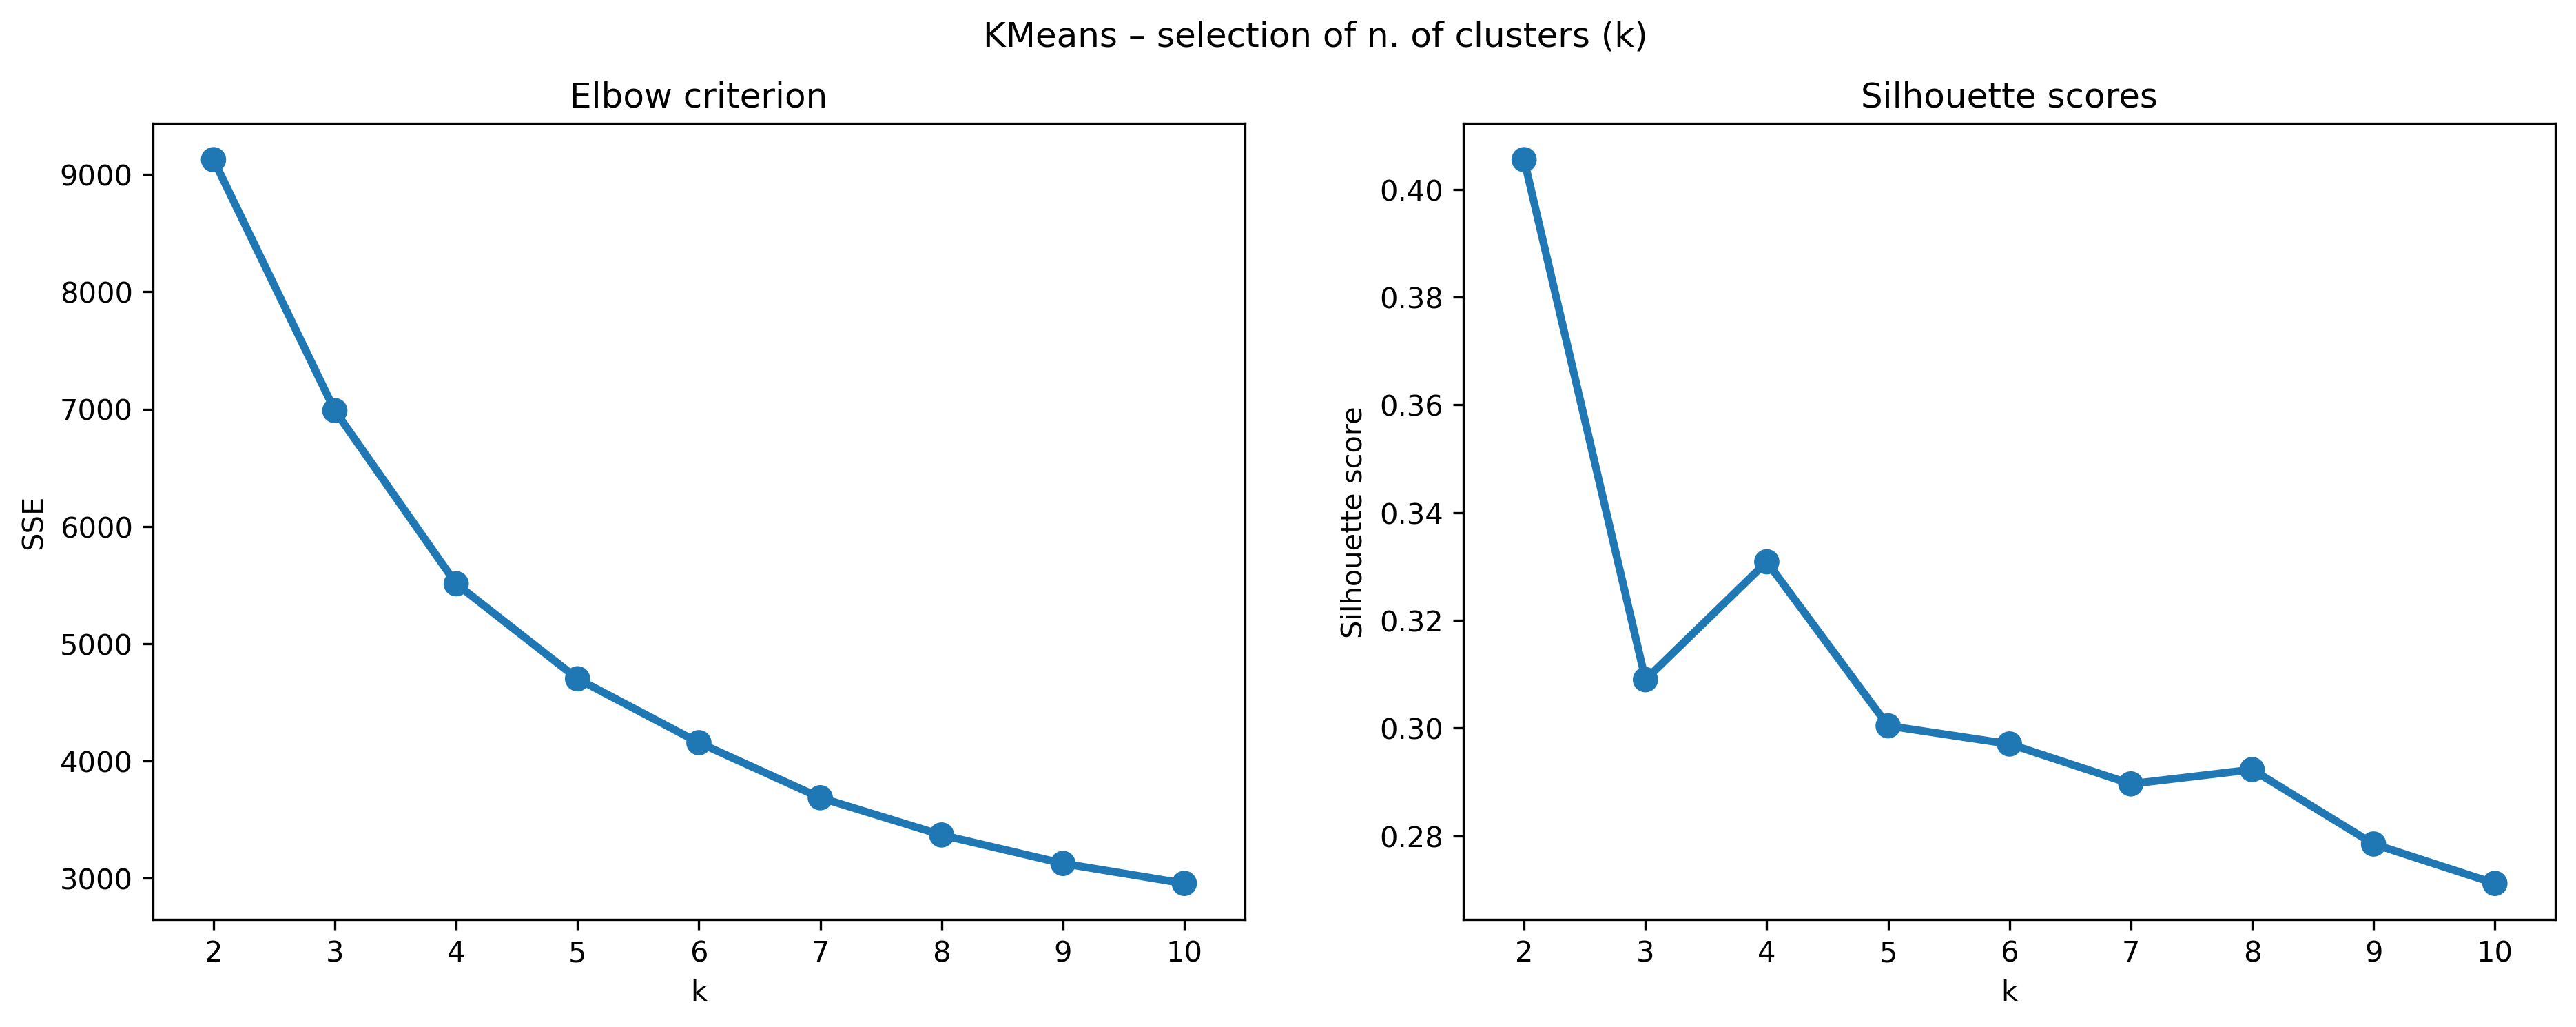

In [40]:
fig, axes = plt.subplots(1,2, figsize=(15,5), dpi=300)

sns.pointplot(x=list(sse.keys()), y=list(sse.values()), ax=axes[0])
axes[0].set_title("Elbow criterion")
axes[0].set_xlabel('k'); axes[0].set_ylabel('SSE')

sns.pointplot(x=list(sil_scores.keys()), y=list(sil_scores.values()), ax=axes[1])
axes[1].set_title("Silhouette scores")
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette score')
plt.suptitle("KMeans – selection of n. of clusters (k)")
plt.show()

### Model interpretation

In [41]:
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
kmeans.fit(datamart_normalized)
labels_k2 = kmeans.labels_

datamart_rfm_k = datamart_rfm.assign(Cluster = labels_k2)
datamart_rfm_k.groupby('Cluster').mean().round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,311.12,32.09,559.88
1,60.73,262.62,5914.93


In [42]:
kmeans = KMeans(n_clusters=4, random_state=1, n_init=10)
kmeans.fit(datamart_normalized)
labels_k4 = kmeans.labels_

datamart_rfm_k = datamart_rfm.assign(Cluster = labels_k4)
datamart_rfm_k.groupby('Cluster').mean().round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,26.70,58.04,896.77
1,270.50,92.31,1704.16
2,381.87,15.20,281.72
3,28.28,421.30,10046.31


We assign cluster labels to original dataframe.

In [43]:
datamart_k = datamart.assign(k2 = labels_k2, k4 = labels_k4)
datamart_normalized_k = datamart_normalized_df.assign(CustomerID = datamart_k['CustomerID'], k2 = labels_k2, k4 = labels_k4)

datamart_k

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,k2,k4
0,12346.0,317,34,77556.46,2,2,4,224,8,1,1
1,12347.0,31,242,5408.50,3,4,4,344,11,1,3
2,12348.0,67,51,2019.40,3,2,3,323,8,1,1
3,12349.0,10,175,4428.69,4,4,4,444,12,1,3
4,12350.0,302,17,334.40,2,1,1,211,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...
5845,18283.0,1,936,2528.65,4,4,4,444,12,1,3
5846,18284.0,423,28,461.68,1,2,2,122,5,0,2
5847,18285.0,652,12,427.00,1,1,2,112,4,0,2
5848,18286.0,468,67,1296.43,1,3,3,133,7,0,1


In [44]:
k2 = datamart_k.groupby('k2').agg(
    Size=('CustomerID', 'count'),
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    MonetaryValue=('MonetaryValue', 'mean')
); display(k2.round())

k4 = datamart_k.groupby('k4').agg(
    Size=('CustomerID', 'count'),
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    MonetaryValue=('MonetaryValue', 'mean')
); display(k4.round())

,Size,Recency,Frequency,MonetaryValue
k2,,,,
0,3245,311.0,32.0,560.0
1,2605,61.0,263.0,5915.0


,Size,Recency,Frequency,MonetaryValue
k4,,,,
0,1200,27.0,58.0,897.0
1,1714,270.0,92.0,1704.0
2,1666,382.0,15.0,282.0
3,1270,28.0,421.0,10046.0


In [45]:
datamart_normalized_k

,Recency,Frequency,MonetaryValue,CustomerID,k2,k4
0,0.830871,-0.285081,3.195948,12346.0,1,1
1,-0.592041,1.078302,1.278958,12347.0,1,3
2,-0.120348,-0.003408,0.569780,12348.0,1,1
3,-1.284490,0.853117,1.135082,12349.0,1,3
4,0.801204,-0.766603,-0.724671,12350.0,0,2
...,...,...,...,...,...,...
5845,-2.693736,2.017994,0.731664,18283.0,1,3
5846,1.007423,-0.419959,-0.492494,18284.0,0,2
5847,1.272231,-1.008569,-0.548706,18285.0,0,2
5848,1.069297,0.186150,0.250751,18286.0,0,1


In [46]:
datamart_normalized_melt = pd.melt(datamart_normalized_k, id_vars=['CustomerID', 'k2', 'k4'], value_vars=['Recency', 'Frequency', 'MonetaryValue'], var_name='Attribute', value_name='Value')
datamart_normalized_melt[['k2', 'k4']] = datamart_normalized_melt[['k2', 'k4']].astype('string')
datamart_normalized_melt

,CustomerID,k2,k4,Attribute,Value
0,12346.0,1,1,Recency,0.830871
1,12347.0,1,3,Recency,-0.592041
2,12348.0,1,1,Recency,-0.120348
3,12349.0,1,3,Recency,-1.284490
4,12350.0,0,2,Recency,0.801204
...,...,...,...,...,...
17545,18283.0,1,3,MonetaryValue,0.731664
17546,18284.0,0,2,MonetaryValue,-0.492494
17547,18285.0,0,2,MonetaryValue,-0.548706
17548,18286.0,0,1,MonetaryValue,0.250751


/Users/antonio.buzzelli/Library/jupyterlab-desktop/jlab_server/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antonio.buzzelli/Library/jupyterlab-desktop/jlab_server/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antonio.buzzelli/Library/jupyterlab-desktop/jlab_server/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antonio.buzzell

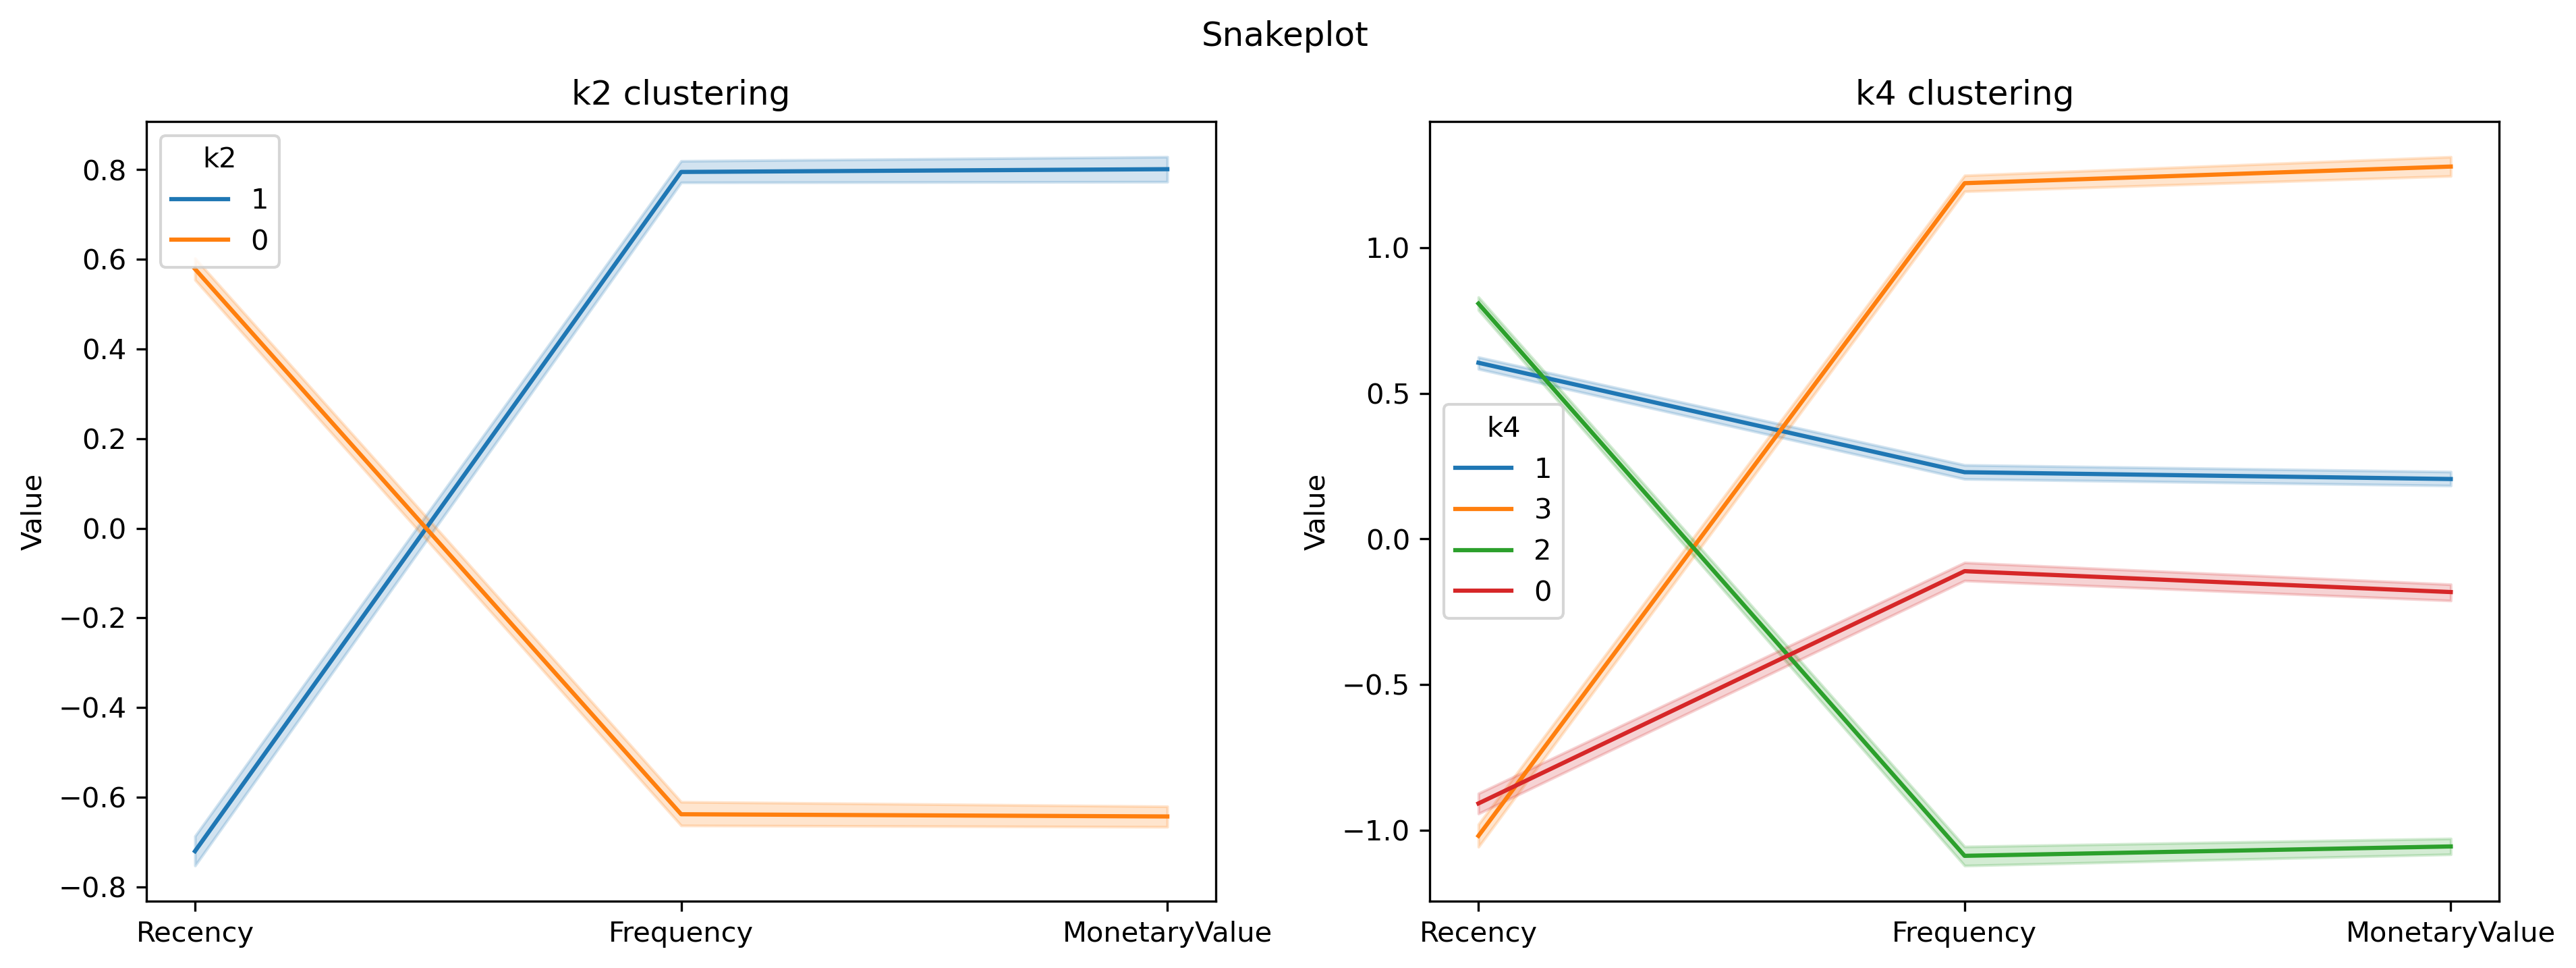

In [47]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
sns.lineplot(datamart_normalized_melt, x='Attribute', y='Value', hue='k2', ax=ax[0])
ax[0].set_xlabel(''); ax[0].set_title("k2 clustering")
sns.lineplot(datamart_normalized_melt, x='Attribute', y='Value', hue='k4', ax=ax[1])
ax[1].set_xlabel(''); ax[1].set_title("k4 clustering")
plt.suptitle("Snakeplot")
plt.show()

In [48]:
pop_avg = datamart_k[['Recency', 'Frequency', 'MonetaryValue']].mean()
pop_avg

Recency           199.620855
Frequency         134.742564
MonetaryValue    2944.481776
dtype: float64

In [49]:
cluster_avg_k2 = datamart_k.groupby('k2')[['Recency', 'Frequency', 'MonetaryValue']].mean()
rel_imp_k2 = cluster_avg_k2 / pop_avg - 1
display(cluster_avg_k2)

,Recency,Frequency,MonetaryValue
k2,,,
0,311.122650,32.088444,559.882913
1,60.725144,262.616891,5914.932182


In [50]:
cluster_avg_k4 = datamart_k.groupby('k4')[['Recency', 'Frequency', 'MonetaryValue']].mean()
rel_imp_k4 = cluster_avg_k4 / pop_avg - 1
display(cluster_avg_k4)

,Recency,Frequency,MonetaryValue
k4,,,
0,26.700000,58.045000,896.768044
1,270.496499,92.312135,1704.160891
2,381.868547,15.198079,281.721933
3,28.281890,421.296850,10046.311990


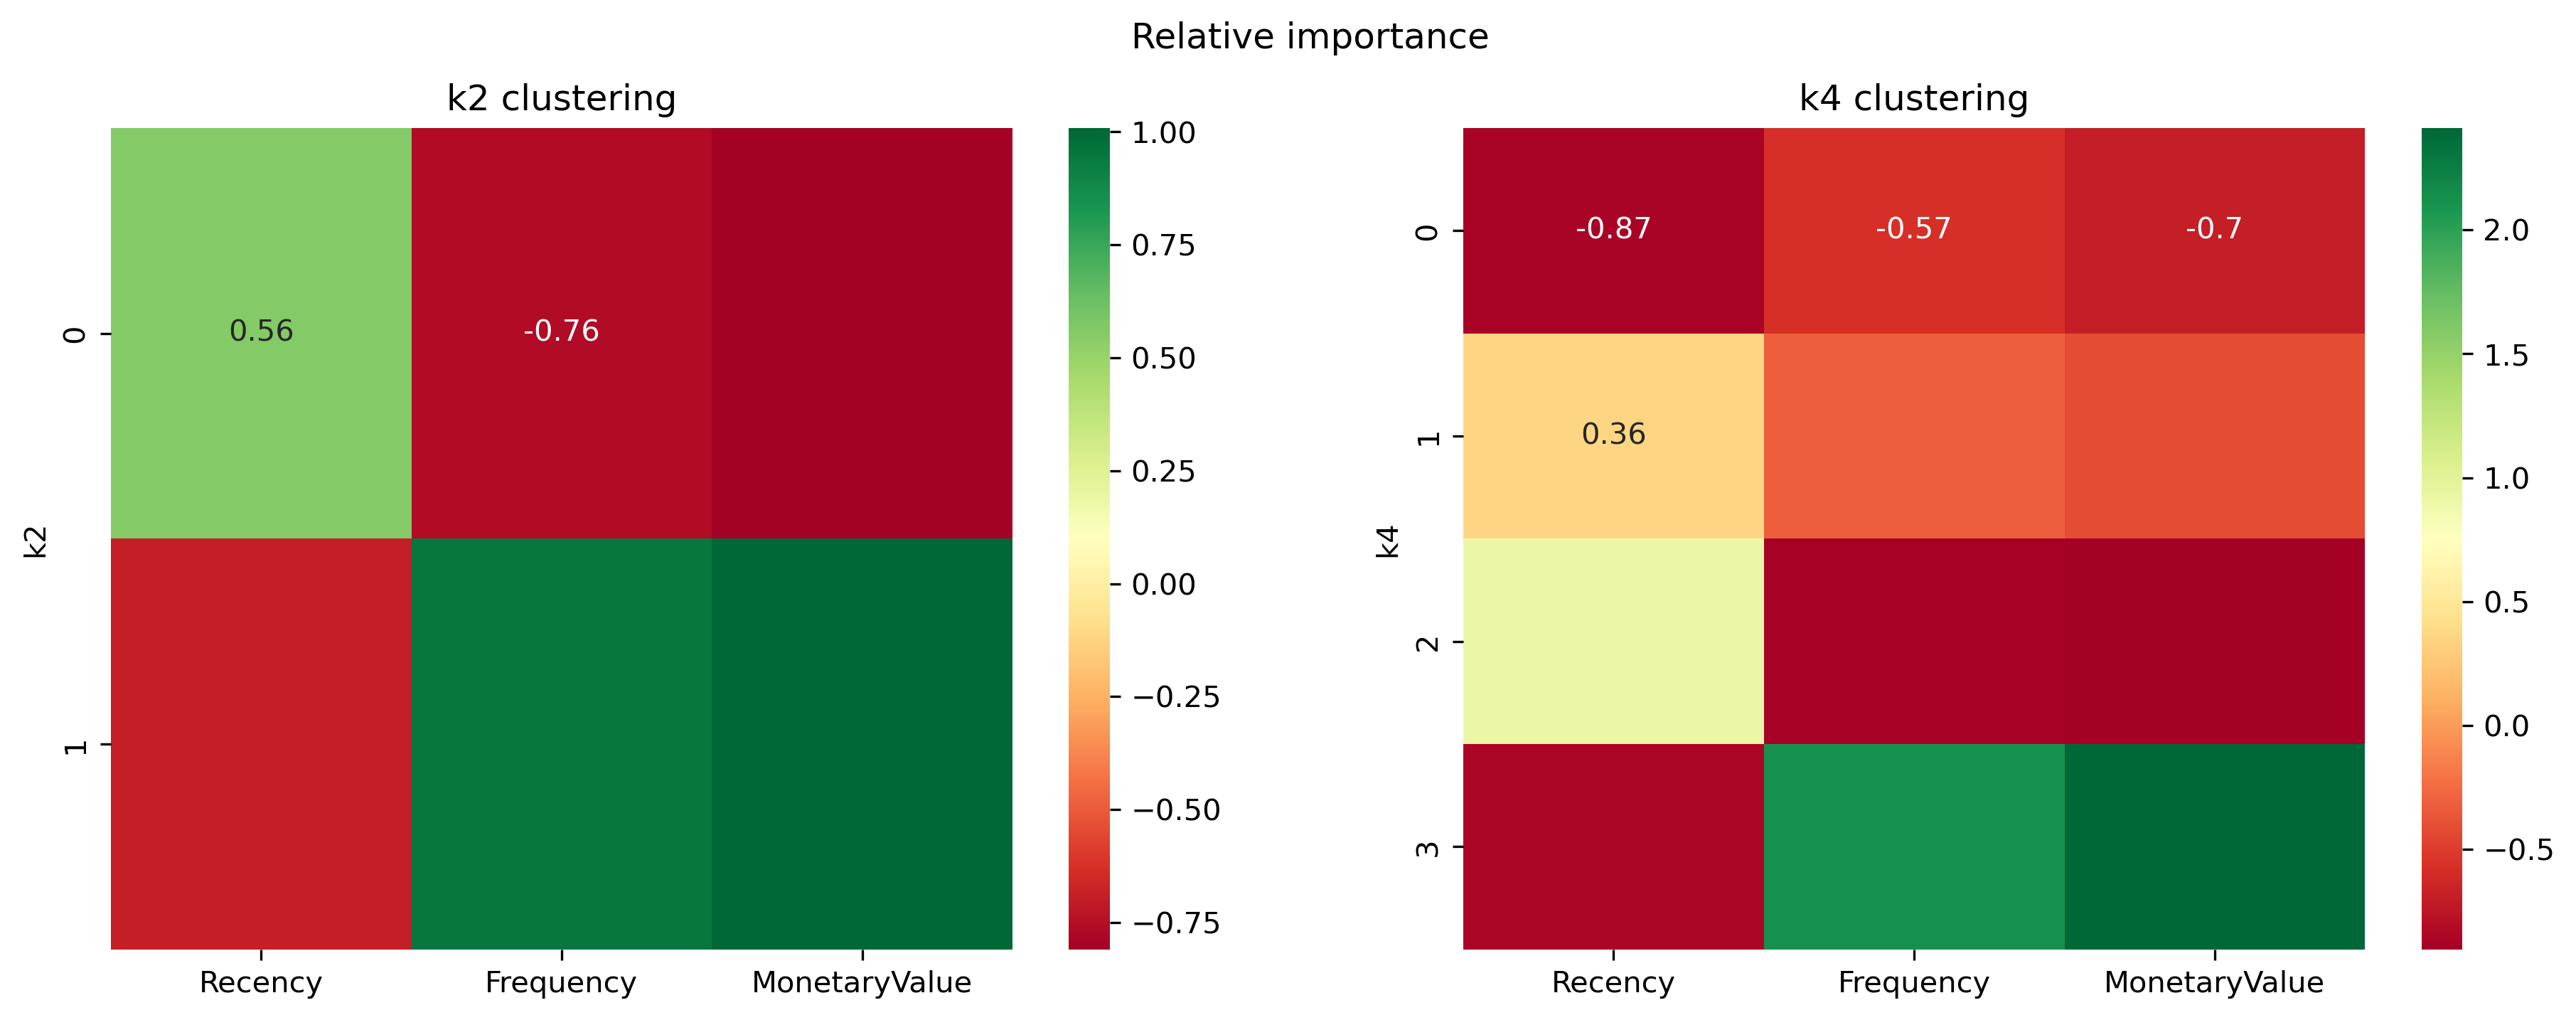

In [51]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
sns.heatmap(rel_imp_k2, annot=True, cmap='RdYlGn', ax=ax[0])
ax[0].set_title('k2 clustering')
sns.heatmap(rel_imp_k4, annot=True, cmap='RdYlGn', ax=ax[1])
ax[1].set_title('k4 clustering')
plt.suptitle("Relative importance")
plt.show()